$\textbf{Polynomial Interpolation: Exploring Stability and Accuracy}$

The Importance of Chebyshev Nodes

$\textbf{Olivia Gette}$

$\textbf{Exposition}$

Polynomial interpolation is a way to find a polynomial that passes through a set of points. This is used to estimate or approximate unknown values. For example, given some data points, we can use interpolation to create a smooth curve that goes through all the points.

One method for interpolation is to use the Vandermonde matrix. This involves solving a system of equations to find the polynomial's coefficients. However, this approach is not very stable, especially if there are many points or if the points are evenly spaced. This happens because the Vandermonde matrix can make small errors grow large during calculations, leading to inaccurate results. There are better methods, like Lagrange and Barycentric interpolation, that aim to solve this problem. Lagrange interpolation uses special "building block" polynomials to create the final interpolating polynomial. Barycentric interpolation is a faster and more stable version of Lagrange interpolation. These methods avoid the problems caused by the Vandermonde matrix.

$\textbf{Summary}$

Polynomial interpolation finds a polynomial that passes through all the given points. For n points, the polynomial will have a degree of at most n-1. The Vandermonde matrix method solves this problem by finding the polynomial's coefficients, but it is prone to errors because it is sensitive to small changes in the data. This sensitivity increases when the points are evenly spaced, which can make the polynomial behave poorly.

Lagrange interpolation uses a different approach. Instead of solving equations, it builds the polynomial using smaller polynomials, called basis polynomials, that are designed to pass through each individual point. While this avoids some of the issues with the Vandermonde matrix, it can still be slow to compute.

Barycentric interpolation improves on Lagrange interpolation by precomputing certain values (weights) that make the calculations faster and more stable. This method is also easier to use for large datasets. Using Chebyshev nodes (which are spread out unevenly, and clustered towards edges) can make the interpolation more accurate and reduce errors, specifically near the edges of the data.

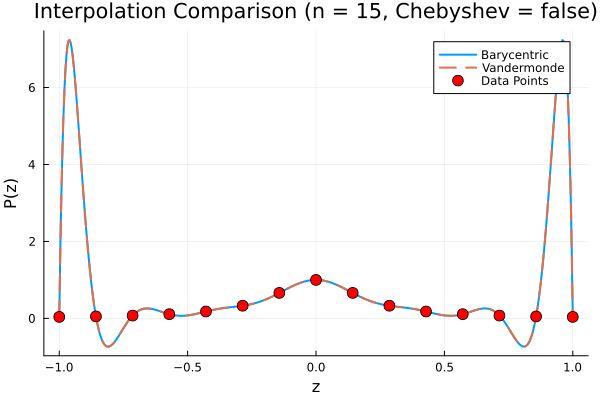

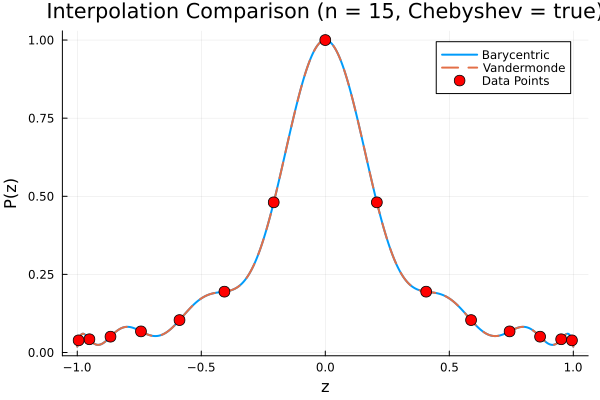

In [5]:
# I am going to compare the stability and accuracy of these methods, also using Chebyshev nodes to compare differences
using LinearAlgebra
using Plots

# Lagrange interpolating polynomial --> not used in the code anymore
function lagrange_interpolant(x::Vector{Float64}, y::Vector{Float64}, z::Float64)
    n = length(x)
    P = 0.0
    for i in 1:n
        basis = 1.0
        for j in 1:n
            if j != i
                # compute the product
                basis *= (z - x[j]) / (x[i] - x[j])
            end
        end
        # add the weighted contribution of the basis polynomial
        P += basis * y[i]
    end
    return P
end

# Barycentric interpolation weights, weights depend only on the x values and are reused for all interpolations
function barycentric_weights(x::Vector{Float64})
    n = length(x)
    w = ones(Float64, n)
    for i in 1:n
        for j in 1:n
            if i != j
                # compute weights by dividing over all pair differences
                w[i] /= (x[i] - x[j])
            end
        end
    end
    return w
end

# evaluate Barycentric interpolation polynomial at a given point z --> uses precomputed weights for efficiency.
function barycentric_interpolant(w::Vector{Float64}, x::Vector{Float64}, y::Vector{Float64}, z::Float64)
    numerator = 0.0
    denominator = 0.0
    for i in 1:length(x)
        # if z matches a node, return the corresponding y value directly
        if z == x[i]
            return y[i]
        end
        # compute term for the current basis function
        term = w[i] / (z - x[i])
        # weighted contribution to the numerator
        numerator += term * y[i]
        # contribution to the denominator
        denominator += term
    end
    # Evaluate the polynomial by dividing numerator by denominator
    return numerator / denominator
end

# Vandermonde method --> computing coefficients
function vandermonde_coefficients(x::Vector{Float64}, y::Vector{Float64})
    # construct vandermonde matrix
    V = [x[i]^(j-1) for i in 1:length(x), j in 1:length(x)]
    # solve system to find coefficient
    return V \ y
end

# evaluate the Vandermonde interpolation polynomial at a given point z using found coefficients
function vandermonde_interpolant(c::Vector{Float64}, z::Float64)
    n = length(c)
    P = 0.0
    for i in 1:n
        # compute the polynomial by summing the terms with powers of z
        P += c[i] * z^(i-1)
    end
    return P
end

# generate Chebyshev nodes --> minimizes the Runge phenomenon by clustering near interval edges
function chebyshev_nodes(n::Int, a::Float64, b::Float64)
    return [(a + b)/2 + (b - a)/2 * cos((2i - 1) / (2n) * pi) for i in 1:n]
end

# defining Runge's function, highlights instability
function runge_function(x::Float64)
    return 1 / (1 + 25 * x^2)
end

# main comparison
function compare_interpolation(n::Int, use_chebyshev::Bool)
    a, b = -1.0, 1.0  # Range for interpolation
    # generate either Chebyshev nodes or equispaced for interpolation
    # ensuring x is a vector
    x = use_chebyshev ? chebyshev_nodes(n, a, b) : collect(range(a, b, length = n))
    # evaluate the nodes
    y = runge_function.(x)
    # points where the interpolation will be evaluated for plotting
    z_values = range(a, b, length = 500)

    # Barycentric interpolation
    weights = barycentric_weights(x)
    barycentric_values = [barycentric_interpolant(weights, x, y, z) for z in z_values]

    # Vandermonde interpolation
    coeffs = vandermonde_coefficients(x, y)
    vandermonde_values = [vandermonde_interpolant(coeffs, z) for z in z_values]

    # plot interpolation
    plot(z_values, barycentric_values, label = "Barycentric", linewidth = 2)
    plot!(z_values, vandermonde_values, label = "Vandermonde", linewidth = 2, linestyle = :dash)
    scatter!(x, y, label = "Data Points", color = :red, marker = :circle, markersize = 6)
    title!("Interpolation Comparison (n = $n, Chebyshev = $use_chebyshev)")
    xlabel!("z")
    ylabel!("P(z)")
end

# test with equispaced points (Runge phenomenon)
withoutChebyshev = compare_interpolation(15, false)  
# test with Chebyshev nodes
withChebyshev = compare_interpolation(15, true)  

display(withoutChebyshev)
display(withChebyshev)

This code compares two interpolation methods: Barycentric and Vandermonde, applied to Runge's function over a range of values -1 to 1. It creates two plots, one using 15 equispaced nodes and another using 15 Chebyshev nodes.

In the first plot, equispaced nodes are used (shown using red dots). The interpolation produces a polynomial that oscillates a lot, especially near the edges of the interval. This is called the Runge phenomenon and it happens because equispaced points can make interpolation unstable. Despite the oscillations, the curves from the Barycentric and Vandermonde methods overlap almost perfectly, meaning both methods correctly compute the same polynomial.

In the second plot, Chebyshev nodes are used instead. These nodes are closer together near the edges, which reduces the oscillations and makes the interpolating polynomial much smoother. The result closely matches Runge's function, showing how effective Chebyshev nodes are for improving stability. Again, the Barycentric and Vandermonde methods produce the same results.

Chebyshev nodes make interpolation more accurate and stable, while both Barycentric and Vandermonde methods work well when the nodes are chosen wisely.

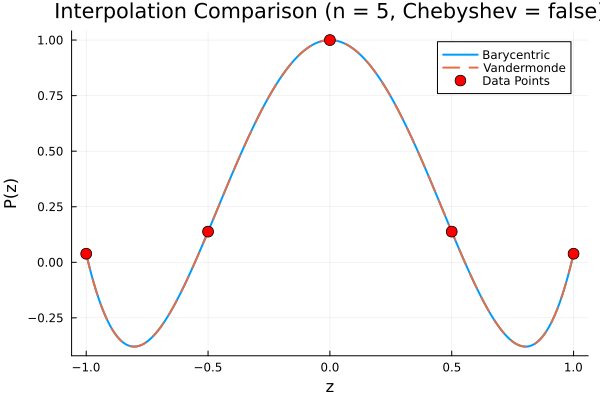

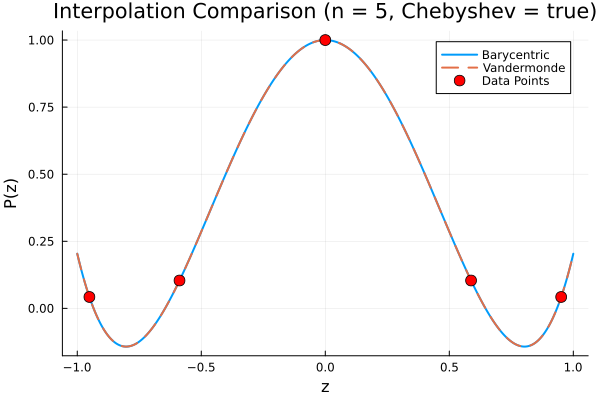

In [7]:
# test with low n
# test with equispaced points (Runge phenomenon)
little_num1 = compare_interpolation(5, false)  
# test with Chebyshev nodes
little_num2 = compare_interpolation(5, true)  

display(little_num1)
display(little_num2)

In the first plot, you can see that n is still low enough for the interpolation to remain stable, meaning the 2 plots' interpolation graphs look about the same, unlike when n = 15.

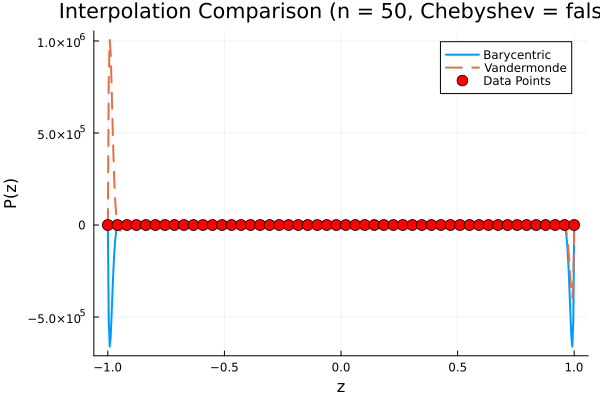

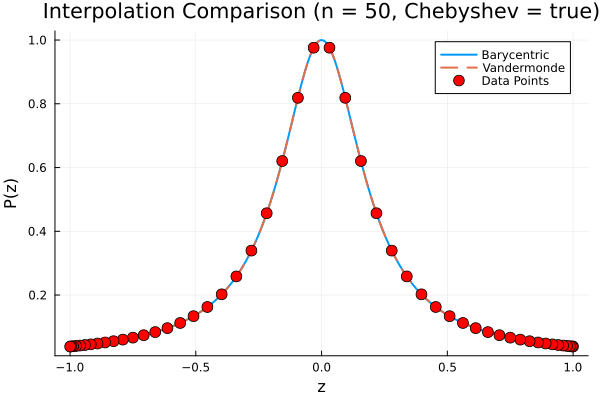

In [9]:
# test with high n
# test with equispaced points (Runge phenomenon)
big_num1 = compare_interpolation(50, false)  
# test with Chebyshev nodes
big_num2 = compare_interpolation(50, true)  

display(big_num1)
display(big_num2)

Here, with the higher n value of 50, we can see that the first plot with the equispaced nodes is unstable and doesn't really give us a good plot. On the other hand, the second plot with the Chebyshev nodes is a better plot of the interpolation.

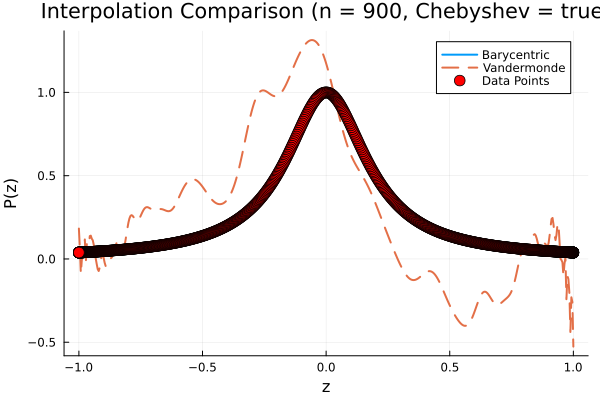

In [11]:
# test high num on just Chebyshev nodes
compare_interpolation(900, true)

I wanted to test how high the number of points had to be to make the Vandermonde plot go off, which ended up being a very high number of 900. You can see the little errors have been amplified now and completely threw off the plot, having many oscillations.

$\textbf{What I've Learned}$

Through this project, I learned how different interpolation methods, such as Barycentric and Vandermonde, compare in terms of stability and accuracy, especially when applied to functions like Runge's function. I also explored the advantages of using Chebyshev nodes over equispaced nodes in reducing interpolation errors and mitigating the Runge phenomenon.

To extend this work, I could analyze these methods on higher-dimensional interpolation problems or see how they do with noisy data(data with errors). I could also look into other node distributions or adaptive interpolation techniques to improve accuracy further.